In [ ]:
from __future__ import print_function, division
from builtins import range, input
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from collections import Counter
from scipy.sparse import lil_matrix, csr_matrix, save_npz, load_npz
from keras.layers import Input, Dropout, Dense
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.models import Model
import keras.backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/reccomender system/data/rating.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [ ]:
# note:
# user ids are ordered sequentially from 1..138493
# with no missing numbers
# movie ids are integers from 1..131262
# NOT all movie ids appear
# there are only 26744 movie ids
# write code to check it yourself!


# make the user ids go from 0...N-1

In [ ]:
# make the user ids go from 0...N-1
df.userId = df.userId - 1

# create a mapping for movie ids
unique_movie_ids = set(df.movieId.values)
movie2idx = {}
count = 0
for movie_id in unique_movie_ids:
  movie2idx[movie_id] = count
  count += 1

# add them to the data frame
# takes awhile
df['movie_idx'] = df.apply(lambda row: movie2idx[row.movieId], axis=1)
df = df.drop(columns=['timestamp'])


In [ ]:
df.to_csv('/content/drive/MyDrive/reccomender system/edited_rating.csv', index=False)
df.head()

,userId,movieId,rating,movie_idx
0,0,2,3.5,2
1,0,29,3.5,29
2,0,32,3.5,32
3,0,47,3.5,47
4,0,50,3.5,50


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/reccomender system/edited_rating.csv')
print("original dataframe size:", len(df))

original dataframe size: 20000263


In [ ]:
N = df.userId.max() + 1 # number of users
M = df.movie_idx.max() + 1 # number of movies

user_ids_count = Counter(df.userId)
movie_ids_count = Counter(df.movie_idx)

# number of users and movies we would like to keep
n = 10000
m = 2000

user_ids = [u for u, c in user_ids_count.most_common(n)]
movie_ids = [m for m, c in movie_ids_count.most_common(m)]

# make a copy, otherwise ids won't be overwritten
df_small = df[df.userId.isin(user_ids) & df.movie_idx.isin(movie_ids)].copy()
df_small.head()

,userId,movieId,rating,movie_idx
960,10,1,4.5,1
961,10,10,2.5,10
962,10,19,3.5,19
963,10,32,5.0,32
964,10,39,4.5,39


In [ ]:
# need to remake user ids and movie ids since they are no longer sequential
new_user_id_map = {}
i = 0
for old in user_ids:
  new_user_id_map[old] = i
  i += 1
print("i:", i)

i: 10000


In [ ]:
new_movie_id_map = {}
j = 0
for old in movie_ids:
  new_movie_id_map[old] = j
  j += 1
print("j:", j)

j: 2000


In [ ]:
print("Setting new ids")
df_small.loc[:, 'userId'] = df_small.apply(lambda row: new_user_id_map[row.userId], axis=1)
df_small.loc[:, 'movie_idx'] = df_small.apply(lambda row: new_movie_id_map[row.movie_idx], axis=1)

Setting new ids


In [ ]:
# df_small.drop(columns=['userId', 'movie_idx'])
# df_small.rename(index=str, columns={'new_userId': 'userId', 'new_movie_idx': 'movie_idx'})
print("max user id:", df_small.userId.max())
print("max movie id:", df_small.movie_idx.max())

max user id: 9999
max movie id: 1999


In [ ]:
print("small dataframe size:", len(df_small))
df_small.to_csv('/content/drive/MyDrive/reccomender system/small_rating.csv', index=False)

small dataframe size: 5392025


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/reccomender system/small_rating.csv')
print('length: ',len(df))
df.head()

length:  5392025


,userId,movieId,rating,movie_idx
0,7307,1,4.5,10
1,7307,10,2.5,68
2,7307,19,3.5,143
3,7307,32,5.0,19
4,7307,39,4.5,85


In [ ]:
N = df.userId.max() + 1 # number of users
M = df.movie_idx.max() + 1 # number of movies

# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

In [ ]:
# a dictionary to tell us which users have rated which movies
user2movie = {}
# a dicationary to tell us which movies have been rated by which users
movie2user = {}
# a dictionary to look up ratings
usermovie2rating = {}
print("Calling: update_user2movie_and_movie2user")
count = 0

Calling: update_user2movie_and_movie2user


In [ ]:
def update_user2movie_and_movie2user(row):
  global count
  count += 1
  if count % 100000 == 0:
    print("processed: %.3f" % (float(count)/cutoff))

  i = int(row.userId)
  j = int(row.movie_idx)
  if i not in user2movie:
    user2movie[i] = [j]
  else:
    user2movie[i].append(j)

  if j not in movie2user:
    movie2user[j] = [i]
  else:
    movie2user[j].append(i)

  usermovie2rating[(i,j)] = row.rating

df_train.apply(update_user2movie_and_movie2user, axis=1)

# test ratings dictionary
usermovie2rating_test = {}
print("Calling: update_usermovie2rating_test")
count = 0

processed: 0.023
processed: 0.046
processed: 0.070
processed: 0.093
processed: 0.116
processed: 0.139
processed: 0.162
processed: 0.185
processed: 0.209
processed: 0.232
processed: 0.255
processed: 0.278
processed: 0.301
processed: 0.325
processed: 0.348
processed: 0.371
processed: 0.394
processed: 0.417
processed: 0.440
processed: 0.464
processed: 0.487
processed: 0.510
processed: 0.533
processed: 0.556
processed: 0.580
processed: 0.603
processed: 0.626
processed: 0.649
processed: 0.672
processed: 0.695
processed: 0.719
processed: 0.742
processed: 0.765
processed: 0.788
processed: 0.811
processed: 0.835
processed: 0.858
processed: 0.881
processed: 0.904
processed: 0.927
processed: 0.950
processed: 0.974
processed: 0.997
Calling: update_usermovie2rating_test


In [ ]:
def update_usermovie2rating_test(row):
  global count
  count += 1
  if count % 100000 == 0:
    print("processed: %.3f" % (float(count)/len(df_test)))

  i = int(row.userId)
  j = int(row.movie_idx)
  usermovie2rating_test[(i,j)] = row.rating
df_test.apply(update_usermovie2rating_test, axis=1)

# note: these are not really JSONs
with open('user2movie.json', 'wb') as f:
  pickle.dump(user2movie, f)

with open('movie2user.json', 'wb') as f:
  pickle.dump(movie2user, f)

with open('usermovie2rating.json', 'wb') as f:
  pickle.dump(usermovie2rating, f)

with open('usermovie2rating_test.json', 'wb') as f:
  pickle.dump(usermovie2rating_test, f)

processed: 0.093
processed: 0.185
processed: 0.278
processed: 0.371
processed: 0.464
processed: 0.556
processed: 0.649
processed: 0.742
processed: 0.835
processed: 0.927


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/reccomender system/edited_rating.csv')
df.head()

,userId,movieId,rating,movie_idx
0,0,2,3.5,2
1,0,29,3.5,29
2,0,32,3.5,32
3,0,47,3.5,47
4,0,50,3.5,50


In [ ]:
N = df.userId.max() + 1 # number of users
M = df.movie_idx.max() + 1 # number of movies

# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

A = lil_matrix((N, M))
print("Calling: update_train")

Calling: update_train


In [ ]:
count = 0
def update_train(row):
  global count
  count += 1
  if count % 100000 == 0:
    print("processed: %.3f" % (float(count)/cutoff))

  i = int(row.userId)
  j = int(row.movie_idx)
  A[i,j] = row.rating
df_train.apply(update_train, axis=1)

processed: 0.006
processed: 0.012
processed: 0.019
processed: 0.025
processed: 0.031
processed: 0.037
processed: 0.044
processed: 0.050
processed: 0.056
processed: 0.062
processed: 0.069
processed: 0.075
processed: 0.081
processed: 0.087
processed: 0.094
processed: 0.100
processed: 0.106
processed: 0.112
processed: 0.119
processed: 0.125
processed: 0.131
processed: 0.137
processed: 0.144
processed: 0.150
processed: 0.156
processed: 0.162
processed: 0.169
processed: 0.175
processed: 0.181
processed: 0.187
processed: 0.194
processed: 0.200
processed: 0.206
processed: 0.212
processed: 0.219
processed: 0.225
processed: 0.231
processed: 0.237
processed: 0.244
processed: 0.250
processed: 0.256
processed: 0.262
processed: 0.269
processed: 0.275
processed: 0.281
processed: 0.287
processed: 0.294
processed: 0.300
processed: 0.306
processed: 0.312
processed: 0.319
processed: 0.325
processed: 0.331
processed: 0.337
processed: 0.344
processed: 0.350
processed: 0.356
processed: 0.362
processed: 0.3

259679      None
10906497    None
18801861    None
7982205     None
9646487     None
            ... 
4205144     None
16922598    None
166564      None
6643421     None
10370042    None
Length: 16000210, dtype: object

In [ ]:
# mask, to tell us which entries exist and which do not
A = A.tocsr()
mask = (A > 0)
save_npz("Atrain.npz", A)

# test ratings dictionary
A_test = lil_matrix((N, M))
print("Calling: update_test")

Calling: update_test


In [ ]:
count = 0
def update_test(row):
  global count
  count += 1
  if count % 100000 == 0:
    print("processed: %.3f" % (float(count)/len(df_test)))

  i = int(row.userId)
  j = int(row.movie_idx)
  A_test[i,j] = row.rating
df_test.apply(update_test, axis=1)
A_test = A_test.tocsr()
mask_test = (A_test > 0)
save_npz("Atest.npz", A_test)

processed: 0.025
processed: 0.050
processed: 0.075
processed: 0.100
processed: 0.125
processed: 0.150
processed: 0.175
processed: 0.200
processed: 0.225
processed: 0.250
processed: 0.275
processed: 0.300
processed: 0.325
processed: 0.350
processed: 0.375
processed: 0.400
processed: 0.425
processed: 0.450
processed: 0.475
processed: 0.500
processed: 0.525
processed: 0.550
processed: 0.575
processed: 0.600
processed: 0.625
processed: 0.650
processed: 0.675
processed: 0.700
processed: 0.725
processed: 0.750
processed: 0.775
processed: 0.800
processed: 0.825
processed: 0.850
processed: 0.875
processed: 0.900
processed: 0.925
processed: 0.950
processed: 0.975
processed: 1.000


In [ ]:
# config
batch_size = 128
epochs = 10
reg = 0.0001
# reg = 0

A = load_npz("Atrain.npz")
A_test = load_npz("Atest.npz")
mask = (A > 0) * 1.0
mask_test = (A_test > 0) * 1.0


In [ ]:
# make copies since we will shuffle
A_copy = A.copy()
mask_copy = mask.copy()
A_test_copy = A_test.copy()
mask_test_copy = mask_test.copy()

N, M = A.shape
print("N:", N, "M:", M)
print("N // batch_size:", N // batch_size)

N: 138493 M: 26744
N // batch_size: 1081


In [ ]:
# center the data
mu = A.sum() / mask.sum()
print("mu:", mu)

mu: 3.5254982590853494


In [ ]:
# build the model - just a 1 hidden layer autoencoder
i = Input(shape=(M,))
# bigger hidden layer size seems to help!
x = Dropout(0.7)(i)
x = Dense(700, activation='tanh', kernel_regularizer=l2(reg))(x)
# x = Dropout(0.5)(x)
x = Dense(M, kernel_regularizer=l2(reg))(x)

In [ ]:
def custom_loss(y_true, y_pred):
  mask = K.cast(K.not_equal(y_true, 0), dtype='float32')
  diff = y_pred - y_true
  sqdiff = diff * diff * mask
  sse = K.sum(K.sum(sqdiff))
  n = K.sum(K.sum(mask))
  return sse / n


In [ ]:
def generator(A, M):
  while True:
    A, M = shuffle(A, M)
    for i in range(A.shape[0] // batch_size + 1):
      upper = min((i+1)*batch_size, A.shape[0])
      a = A[i*batch_size:upper].toarray()
      m = M[i*batch_size:upper].toarray()
      a = a - mu * m # must keep zeros at zero!
      # m2 = (np.random.random(a.shape) > 0.5)
      # noisy = a * m2
      noisy = a # no noise
      yield noisy, a

In [ ]:

def test_generator(A, M, A_test, M_test):
  # assumes A and A_test are in corresponding order
  # both of size N x M
  while True:
    for i in range(A.shape[0] // batch_size + 1):
      upper = min((i+1)*batch_size, A.shape[0])
      a = A[i*batch_size:upper].toarray()
      m = M[i*batch_size:upper].toarray()
      at = A_test[i*batch_size:upper].toarray()
      mt = M_test[i*batch_size:upper].toarray()
      a = a - mu * m
      at = at - mu * mt
      yield a, at



In [ ]:
model = Model(i, x)
model.compile(
  loss=custom_loss,
  optimizer=SGD(lr=0.08, momentum=0.9),
  # optimizer='adam',
  metrics=[custom_loss],
)


r = model.fit(
  generator(A, mask),
  validation_data=test_generator(A_copy, mask_copy, A_test_copy, mask_test_copy),
  epochs=epochs,
  steps_per_epoch=A.shape[0] // batch_size + 1,
  validation_steps=A_test.shape[0] // batch_size + 1,
)

Epoch 1/10
1082/1082 [==============================] - 133s 119ms/step - loss: 1.2100 - custom_loss: 0.9420 - val_loss: 1.0897 - val_custom_loss: 0.8262
Epoch 2/10
1082/1082 [==============================] - 131s 121ms/step - loss: 1.0414 - custom_loss: 0.7824 - val_loss: 1.0295 - val_custom_loss: 0.7750
Epoch 3/10
1082/1082 [==============================] - 119s 110ms/step - loss: 0.9907 - custom_loss: 0.7405 - val_loss: 0.9965 - val_custom_loss: 0.7507
Epoch 4/10
1082/1082 [==============================] - 126s 116ms/step - loss: 0.9573 - custom_loss: 0.7157 - val_loss: 0.9724 - val_custom_loss: 0.7350
Epoch 5/10
1082/1082 [==============================] - 126s 116ms/step - loss: 0.9311 - custom_loss: 0.6976 - val_loss: 0.9533 - val_custom_loss: 0.7238
Epoch 6/10
1082/1082 [==============================] - 116s 107ms/step - loss: 0.9100 - custom_loss: 0.6842 - val_loss: 0.9375 - val_custom_loss: 0.7155
Epoch 7/10
1082/1082 [==============================] - 128s 119ms/step - lo

In [ ]:
print(r.history.keys())

dict_keys(['loss', 'custom_loss', 'val_loss', 'val_custom_loss'])


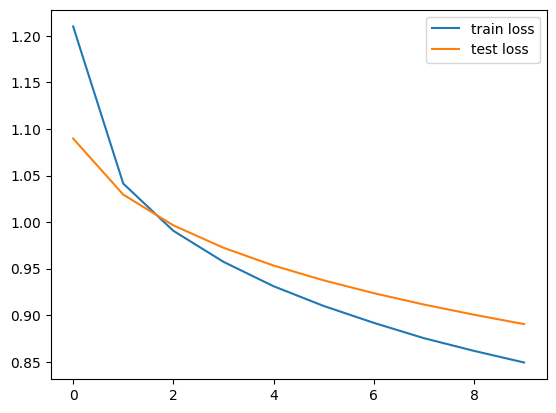

In [ ]:

# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

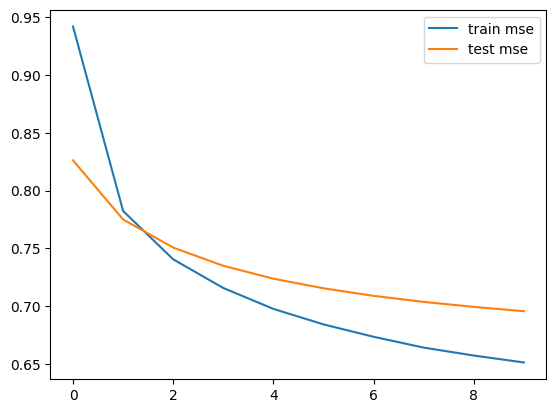

In [ ]:
# plot mse
plt.plot(r.history['custom_loss'], label="train mse")
plt.plot(r.history['val_custom_loss'], label="test mse")
plt.legend()
plt.show()

In [ ]:
import numpy as np

def predict_rating(model, user_id, movie_idx, mu):


    # Prepare input data for prediction
    input_data = np.zeros((1, M))
    input_data[0, movie_idx] = 1  # Set the specified movie index to 1

    # Predict the rating
    prediction = model.predict(input_data)[0, movie_idx]

    # Add back the mean rating to the prediction
    prediction += mu

    return prediction


In [ ]:
user_id_example = 10
movie_idx_example = 20
predicted_rating = predict_rating(model, user_id_example, movie_idx_example, mu)
print(f"Predicted rating for User {user_id_example} and Movie {movie_idx_example}: {predicted_rating}")

1/1 [==============================] - 0s 19ms/step
Predicted rating for User 10 and Movie 20: 3.230940568464927


1/1 [==============================] - 0s 18ms/step
Predicted rating for User 5 and Movie 30: 3.5786449641167444
